In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1.读取数据

In [2]:
datas = pd.read_csv('user_action.csv')
print(datas)

            user_id    item_id  behavior_type  item_category           time
0          98047837  232431562              1           4245  2014-12-06 02
1          97726136  383583590              1           5894  2014-12-09 20
2          98607707   64749712              1           2883  2014-12-18 11
3          98662432  320593836              1           6562  2014-12-06 10
4          98145908  290208520              1          13926  2014-12-16 21
...             ...        ...            ...            ...            ...
12256901   93812622  378365755              1             11  2014-12-13 21
12256902   93812622  177724753              1          12311  2014-12-14 21
12256903   93812622  234391443              1           8765  2014-12-11 16
12256904   93812622   26452000              1           7951  2014-12-08 22
12256905  108404535  362699797              1           9847  2014-12-03 19

[12256906 rows x 5 columns]


**数据共有5个字段，分别是user_id（用户id）、item_id（商品id）、behavior_type（用户行为）、item_category（商品类别）、time（操作时间）。</br>记录共有12256906条。**

In [3]:
print('用户数量',len(set(datas['user_id'])))
print('商品数量',len(set(datas['item_id'])))
print('商品类别数量',len(set(datas['item_category'])))

用户数量 10000
商品数量 2876947
商品类别数量 8916


**可以看出，用户数量为10000，即该数据集表示为1万个用户在淘宝上的1200多万条操作行为记录，其中涉及商品数量有280多万，分布在接近9000个商品类别中**

# 2.数据预处理

In [4]:
# 缺省值情况
datas.isnull().sum()

user_id          0
item_id          0
behavior_type    0
item_category    0
time             0
dtype: int64

**数据无缺省值，应已事先经过处理，接下来处理字段类型，方便后续处理**

In [5]:
# 查看字段类型
datas.dtypes

user_id           int64
item_id           int64
behavior_type     int64
item_category     int64
time             object
dtype: object

**除time字段外，其他类型为int类型。现在处理time字段，该字段包含年月日以及小时，需将年月日与小时进行分割处理**

In [6]:
def splitDate(str):
    return str.split(' ')[0]
def splitHour(str):
    return str.split(' ')[1]
datas['date'] = datas['time'].map(splitDate)
datas['hour'] =  datas['time'].map(splitHour)

In [7]:
datas.head()

,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21


In [8]:
datas.dtypes

user_id           int64
item_id           int64
behavior_type     int64
item_category     int64
time             object
date             object
hour             object
dtype: object

**上述操作已将time字段分割成日期（date）字段和小时（hour）字段，但字段类型为object。
为方便后续计算处理，需把date字段转换成datetime类型，把hour字段转换成int类型。**

In [9]:
datas['hour'] = pd.to_numeric(datas['hour'])
datas['date'] = pd.to_datetime(datas['date'])
datas.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
item_category             int64
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

In [10]:
print("日期：{0} 至 {1}".format(datas['date'].min(),datas['date'].max()))


日期：2014-11-18 00:00:00 至 2014-12-18 00:00:00


**可看出这份数据的时间是从2014年11月18日至12月18日**

# 3.流量分析（PV与UV）

## 3.1 以天数为单位进行流量分析

### 3.1.1 每日页面访问流量情况（PV）

In [11]:
#计算PV，把值保存在pv_daily中
pv_daily = datas.groupby('date')['user_id'].count()
pv_daily=pv_daily.reset_index()
pv_daily=pv_daily.rename(columns={'user_id':'pv_daily'})
pv_daily.head(5)

,date,pv_daily
0,2014-11-18,366701
1,2014-11-19,358823
2,2014-11-20,353429
3,2014-11-21,333104
4,2014-11-22,361355


### 3.1.2 日活跃用户数情况（UV）

In [57]:
# 计算UV情况

#定义函数，去除重复值，并计算去重后的数量
def uniqueSeries(column):
    return len(column.unique())
# 按date进行分组，计算每个日期的UV情况
# uv_daily = datas.groupby('date')['user_id'].map(uniqueSeries)  #map只适用于单列，groupby后数据分成了多列
uv_daily = datas.groupby('date')['user_id'].apply(uniqueSeries)
uv_daily=uv_daily.reset_index()
uv_daily=uv_daily.rename(columns={'user_id':'uv_daily'})
print("打印前5条数据\n",uv_daily.head(5))

打印前5条数据
         date  uv_daily
0 2014-11-18      6343
1 2014-11-19      6420
2 2014-11-20      6333
3 2014-11-21      6276
4 2014-11-22      6187


### 3.1.3 对PV和UV情况进行可视化

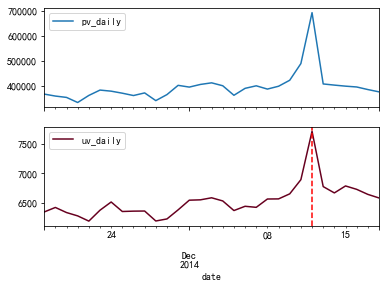

In [13]:
fig, axes = plt.subplots(2,1,sharex=True)
#绘制pv
pv_plot = pv_daily.plot(x='date',y='pv_daily',ax=axes[0])

#绘制uv
uv_plot = uv_daily.plot(x='date', y='uv_daily',ax=axes[1], colormap='RdGy')
# 计算最大值以及其索引号
max_value = uv_daily['uv_daily'].max()
max_index = uv_daily['uv_daily'].idxmax() # max_index 为最大值对应的行索引号
#绘制虚线
# uv_plot.axhline(max_value, color="red", linestyle="--") #绘制横向虚线线
#因为横坐标为日期类型，因此第一个需要输入日期类型，通过max_index获取对于日期
uv_plot.axvline(uv_daily['date'].loc[max_index], color="red", linestyle="--")
# uv_plot.annotate
plt.show()

**由上图可知，pv与uv情况大体一样，而峰值出现在12月12号，而这天正是淘宝双十二活动，符合预期**

## 3.2 基于小时级别的流量分析

### 3.2.1 每小时的PV情况

In [14]:
# 计算每小时的PV
pv_hour = datas.groupby('hour')['user_id'].count()
pv_hour = pv_hour.reset_index()
pv_hour = pv_hour.rename(columns={'user_id':'pv_hour'})
pv_hour

,hour,pv_hour
0,0,517404
1,1,267682
2,2,147090
3,3,98516
4,4,80487
5,5,88296
6,6,158798
7,7,287337
8,8,396106
9,9,485951


### 3.2.2 每小时的UV情况

In [15]:
# 计算每小时的UV
uv_hour = datas.groupby('hour')['user_id'].apply(uniqueSeries)
uv_hour = uv_hour.reset_index()
uv_hour = uv_hour.rename(columns={'user_id':'uv_hour'})
uv_hour

,hour,uv_hour
0,0,5786
1,1,3780
2,2,2532
3,3,1937
4,4,1765
5,5,2030
6,6,3564
7,7,5722
8,8,7108
9,9,7734


### 3.2.3 PV与UV可视化

Text(0.5, 1.0, 'uv_hour')

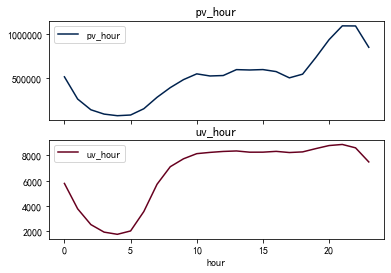

In [16]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')

**从上述可视化图像可知，每天的pv与uv在晚上20点之后达到巅峰，在凌晨时段最低，符合人们日常习惯。
而pv在白天时段（7点-18点）保持稳定（维持在500000左右），18点开始呈上升趋势，说明用户在晚上下班后会更加频繁刷新淘宝页面，浏览淘宝商品。
而uv除了在凌晨阶段（0点-7点）较低之外，其他时间相差不大，说明用户在非睡眠时段都会点开淘宝，但不一定会频繁刷新，有可能是为了打开淘宝查看快递情况，或者关注商品是否有降价情况。**

## 3.3 分析双十二当天的流量情况

In [17]:
datas_1212 = datas.loc[datas['date']=='2014-12-12']
#计算12月12日这天每小时的pv
pv_hour_1212 = datas_1212.groupby('hour')['user_id'].count()
pv_hour_1212 = pv_hour_1212.reset_index()
pv_hour_1212 = pv_hour_1212.rename(columns={'user_id':'pv_hour_1212'})
pv_hour_1212

,hour,pv_hour_1212
0,0,50030
1,1,22761
2,2,11754
3,3,6173
4,4,5168
5,5,6417
6,6,12820
7,7,22177
8,8,28156
9,9,32695


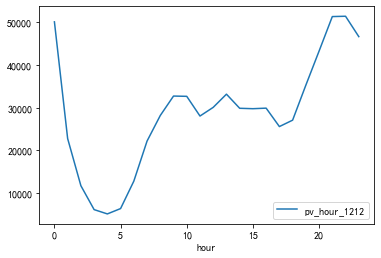

In [18]:
#可视化PV
pv_hour_1212.plot(x='hour',y='pv_hour_1212')

**从上述pv可视化图像可知，用户集中在20点之后频繁浏览淘宝，但与平时不同的是，在凌晨0点时pv值仍处于最高水平，该情况应该与淘宝双十二活动集中在0点有关，用户集中在0点进行抢购，说明双十二活动在很大程度上吸引了用户**

# 4.转化率分析
**该数据集中的用户共有4种行为，分别是浏览、收藏、加购物车、购买。</br>
其中收藏和加购物车的行为没有转化关系，把该两种行为合二为一统称为收藏。</br>
分别计算“浏览—收藏”、“收藏—购买”以及“浏览—购买”的转化率**

## 4.1 基于该月份用户的行为进行分析

In [19]:
behavior = datas.groupby(['behavior_type'])['user_id'].count()
behavior = behavior.reset_index()
behavior = behavior.rename(columns={'user_id':'behavior_count'})
behavior
#浏览、收藏、加购物车、购买，对应取值分别是1、2、3、4

,behavior_type,behavior_count
0,1,11550581
1,2,242556
2,3,343564
3,4,120205


In [58]:
#对收藏和加购物车进行相关性分析 to-do-list

#此处先假设收藏和加入购物车这两个行为没有必然联系
browse_count = behavior.iloc[0,1] #浏览人数

collect_count = behavior.iloc[1,1] #收藏人数
cart_count = behavior.iloc[2,1] # 加入购物车人数

collect_cart_count = collect_count + cart_count #收藏以及加购人数
purchase_count = behavior.iloc[3,1] #购买人数
#print(browse_count,collect_count,cart_count,purchase_count)

#计算转化率，这里计算“浏览-收藏/加购”，“浏览-购买”，“收藏/加购-购买”。
browse_to_collectCart = (collect_cart_count / browse_count) * 100
browse_to_purchase = (purchase_count / browse_count) *100
collectCart_to_purchase = (purchase_count / collect_cart_count) * 100

print("浏览 - 收藏的转化率：",browse_to_collectCart)
print("浏览 - 购买的转化率：",browse_to_purchase)
print("收藏 - 购买的转化率：",collectCart_to_purchase)

浏览 - 收藏的转化率： 5.074376778103197
浏览 - 购买的转化率： 1.04068358119821
收藏 - 购买的转化率： 20.508598921722516


**下面绘制漏斗图**

In [59]:
# 漏斗图
import plotly.express as px
from IPython.display import HTML
browse_count_int = int(browse_count)
collect_cart_count_int = int(collect_cart_count)
purchase_count_int = int(purchase_count)
data1 = pd.DataFrame({
    "number":[browse_count_int,collect_cart_count_int,purchase_count_int],
    "stage":["浏览量", "收藏量", "购买量"]
})
data1

,number,stage
0,11550581,浏览量
1,586120,收藏量
2,120205,购买量


In [60]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    #x=[1000,800,400,100],  # 数据
    #y=["浏览网站","加购","点击支付","支付成功"], # 每个阶段的名称
    x=data1['number'],
    y=data1['stage'],
    textinfo = "value + percent initial +percent previous",   # 显示文本信息 ['label', 'text', 'percent initial', 'percent previous', 'percent total', 'value'] 前面选项的任意组合
    connector = {"line": {"color": "royalblue", "width": 1}})
    )
fig.show()

**由上图可知：<br />
1.“浏览—收藏、加购”的转化率为5%。<br />
2.“收藏—购买”的转化率为21%。<br />
3.“浏览—购买”的转化率为1% <br />
说明用户更倾向于购买已经收藏的商品**

## 4.2 基于双十二当天用户的行为进行分析

In [23]:
datas_1212_behavior = datas_1212.groupby('behavior_type')['user_id'].count()
# 浏览量
browse_count_1212 = datas_1212_behavior[1]
# 收藏、加购量
collect_cart_count_1212 = datas_1212_behavior[2]+datas_1212_behavior[3]
# 购买量
purchase_count_1212 = datas_1212_behavior[4]
print("双十二用户行为转化率：")
print("浏览—收藏的转化率：", (collect_cart_count_1212 / browse_count_1212)*100)
print("收藏—购买的转化率：",(purchase_count_1212/collect_cart_count_1212)*100)
print("浏览—购买的转化率：",(purchase_count_1212/browse_count_1212)*100)

双十二用户行为转化率：
浏览—收藏的转化率： 5.448732437837779
收藏—购买的转化率： 43.631630142472964
浏览—购买的转化率： 2.37737078473033


**制作可视化漏斗图像**

In [24]:
funnel_1212 = go.Figure(go.Funnel(
    #x=[1000,800,400,100],  # 数据
    #y=["浏览网站","加购","点击支付","支付成功"], # 每个阶段的名称
    x=[int(browse_count_1212), int(collect_cart_count_1212), int(purchase_count_1212)],
    y=["双十二浏览量", "双十二收藏、加购量", "双十二购买量"],
    textinfo = "value + percent initial + percent previous",   # 显示文本信息 ['label', 'text', 'percent initial', 'percent previous', 'percent total', 'value'] 前面选项的任意组合
    connector = {"line": {"color": "royalblue", "width": 1}})
    )
funnel_1212.show()

**双十二用户行为转化率情况：<br/>
浏览—收藏的转化率： 5% <br/>
收藏—购买的转化率： 44% <br/>
浏览—购买的转化率： 2% <br/>
从以上转化率得出，在双十二当天“收藏—购买”的转化率高达44%，为平时的2倍之多，说明用户更倾向于在双十二当天购买所收藏的商品，双十二的活动对用户下单起到了很好的促进作用**

# 5. 用户购买频次分析

In [25]:
# 筛选出behavior_type为4的记录，把按照用户id进行分组，挑选出behavior_type列，并进行计数
data_user_buy = datas[datas.behavior_type==4].groupby('user_id')['behavior_type'].count()
data_user_buy = data_user_buy.reset_index()
data_user_buy = data_user_buy.rename(columns={'behavior_type':'behavior_type_4_count'})
data_user_buy

,user_id,behavior_type_4_count
0,4913,6
1,6118,1
2,7528,6
3,7591,21
4,12645,8
...,...,...
8881,142376113,1
8882,142412247,12
8883,142430177,5
8884,142450275,40


**共有8886条记录，说明1万名用户中，有接近9千名用户产生了购买行为**

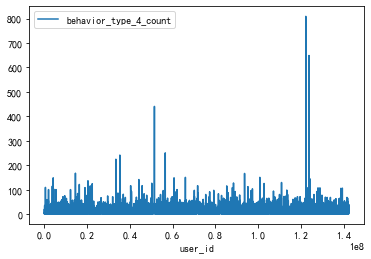

In [26]:
data_user_buy.plot(x='user_id',y='behavior_type_4_count')

**部分数值过高，影响观察，剔除超过200的异常值：**

Text(0, 1.05, '购买次数')

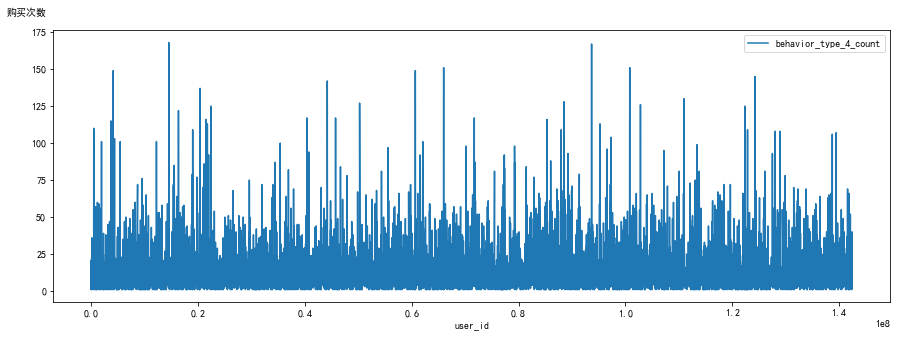

In [89]:
data_user_buy_cleanned = data_user_buy[data_user_buy["behavior_type_4_count"] <200]
data_user_buy_cleanned.plot(x='user_id',y='behavior_type_4_count',figsize=(15,5))
plt.ylabel('购买次数',rotation=0,y=1.05)

**大部分用户的购买次数在1-50之间**

# 6.ARPU分析
ARPU 的计算方法是将总收入除以一段时间内的平均用户数，由于该数据集没有金额，因此把金额改为计算用户的消费次数

In [28]:
#给数据新增一列action，表示用户的操作，具体用于计算用户购买行为（behavior_type=4）的次数
datas['action'] = 1
#对每个日期，按照用户id，用户行为进行分类。即一个用户在同一个日期上，分别计算在该日期上分别操作不同行为多少次
purchase_count = datas.groupby(['date','user_id','behavior_type'])['action'].count()
purchase_count = purchase_count.reset_index()
#每日具有购买行为（behavior_type=4）的人数 / 每日的活跃用户数
arpu = purchase_count.groupby('date').apply(lambda x:x[x['behavior_type']==4]['action'].sum() / len(x['user_id'].unique()))
arpu

date
2014-11-18    0.588050
2014-11-19    0.574143
2014-11-20    0.546660
2014-11-21    0.481358
2014-11-22    0.577016
2014-11-23    0.525184
2014-11-24    0.526025
2014-11-25    0.545426
2014-11-26    0.562058
2014-11-27    0.577135
2014-11-28    0.519955
2014-11-29    0.515906
2014-11-30    0.566860
2014-12-01    0.597341
2014-12-02    0.552824
2014-12-03    0.589977
2014-12-04    0.565151
2014-12-05    0.521282
2014-12-06    0.508075
2014-12-07    0.507007
2014-12-08    0.520871
2014-12-09    0.525282
2014-12-10    0.483464
2014-12-11    0.467943
2014-12-12    1.975518
2014-12-13    0.513282
2014-12-14    0.522346
2014-12-15    0.554590
2014-12-16    0.560410
2014-12-17    0.544182
2014-12-18    0.544819
dtype: float64

Text(0, 1, '日平均消费次数')

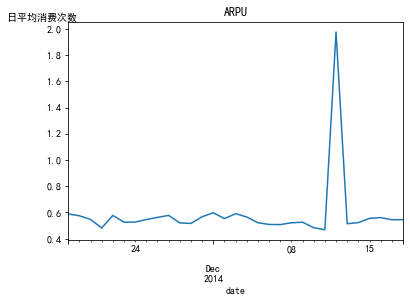

In [83]:
arpu.plot()
plt.title('ARPU')
plt.ylabel('日平均消费次数',rotation=0,y=1)

In [30]:
arpu.mean()

0.5858109446189442

**可以看出，活跃用户每天平均消费次数约为0.6次，在双十二当天到达最高值约2次，为平时的2倍**

## 6.2 下单率

In [31]:
purchase_rate = purchase_count.groupby('date').apply(lambda x:x[x['behavior_type']==4]['action'].count() / len(x['user_id'].unique()))
purchase_rate

date
2014-11-18    0.242630
2014-11-19    0.235358
2014-11-20    0.235591
2014-11-21    0.211918
2014-11-22    0.228059
2014-11-23    0.225326
2014-11-24    0.233994
2014-11-25    0.235711
2014-11-26    0.233915
2014-11-27    0.240132
2014-11-28    0.232994
2014-11-29    0.221240
2014-11-30    0.240477
2014-12-01    0.253209
2014-12-02    0.241985
2014-12-03    0.257707
2014-12-04    0.242689
2014-12-05    0.234490
2014-12-06    0.225466
2014-12-07    0.218468
2014-12-08    0.236289
2014-12-09    0.217636
2014-12-10    0.216777
2014-12-11    0.210183
2014-12-12    0.504793
2014-12-13    0.228601
2014-12-14    0.225855
2014-12-15    0.239723
2014-12-16    0.245207
2014-12-17    0.236339
2014-12-18    0.235795
dtype: float64

Text(1, 0, '日期（天）')

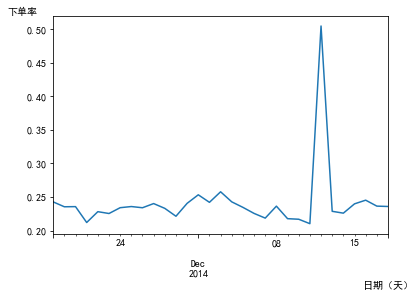

In [79]:
purchase_rate.plot()
plt.ylabel("下单率",rotation=0,y=1)
plt.xlabel("日期（天）",x=1)

**上述数据可知，平时下单率在25%左右，而双十二当天的下单率为50%**

# 7.ARPPU分析

In [33]:
#print(purchase_count)
arppu = purchase_count[purchase_count['behavior_type']==4].groupby(['date','user_id'])['action'].sum()
arppu = arppu.reset_index().rename(columns={'action':'buy_count'})
arppu

,date,user_id,buy_count
0,2014-11-18,54056,1
1,2014-11-18,79824,2
2,2014-11-18,88930,2
3,2014-11-18,247543,5
4,2014-11-18,475826,3
...,...,...,...
49196,2014-12-18,142138619,1
49197,2014-12-18,142168798,2
49198,2014-12-18,142244794,1
49199,2014-12-18,142306361,2


In [34]:
arppu = arppu.groupby('date').apply(lambda x:x['buy_count'].sum() / x['user_id'].count())
arppu

date
2014-11-18    2.423652
2014-11-19    2.439444
2014-11-20    2.320375
2014-11-21    2.271429
2014-11-22    2.530120
2014-11-23    2.330780
2014-11-24    2.248031
2014-11-25    2.313961
2014-11-26    2.402824
2014-11-27    2.403405
2014-11-28    2.231623
2014-11-29    2.331881
2014-11-30    2.357236
2014-12-01    2.359083
2014-12-02    2.284543
2014-12-03    2.289334
2014-12-04    2.328707
2014-12-05    2.223041
2014-12-06    2.253444
2014-12-07    2.320741
2014-12-08    2.204384
2014-12-09    2.413576
2014-12-10    2.230236
2014-12-11    2.226363
2014-12-12    3.913523
2014-12-13    2.245320
2014-12-14    2.312749
2014-12-15    2.313460
2014-12-16    2.285455
2014-12-17    2.302548
2014-12-18    2.310567
dtype: float64

Text(0.9, 0, '日期（天）')

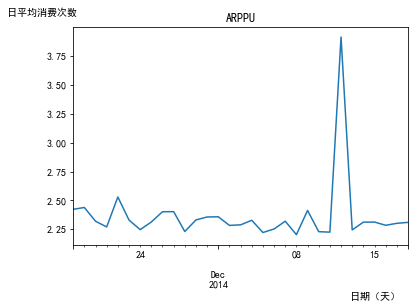

In [70]:
arppu.plot()
plt.title('ARPPU')
plt.ylabel("日平均消费次数",rotation=0,y=1.05)
plt.xlabel("日期（天）",x=0.9)

In [36]:
arppu.describe()

count    31.000000
mean      2.368446
std       0.296108
min       2.204384
25%       2.262436
50%       2.313460
75%       2.358159
max       3.913523
dtype: float64

**可看出，对于有购买行为的用户，其每日平均消费次数为2.3。而双十二当天的人均消费次数为3.9**

# 8.复购情况分析
复购率的计算方式为：复购率 = 复购用户数量 / 有购买行为的用户数量。
其中，复购用户数量是指在两天以上产生了购买行为的用户数量

In [37]:
repay_user_count = datas[datas.behavior_type==4]
repay_user_count = repay_user_count.groupby('user_id')['date'].apply(lambda x: len(x.unique()))
repay_user_count.head(5)

user_id
4913     5
6118     1
7528     6
7591     9
12645    4
Name: date, dtype: int64

In [38]:
repay_ratio = repay_user_count[repay_user_count > 1].count() / repay_user_count.count()
repay_ratio

0.8717083051991897

**用户复购率为87%**

# 9.复购周期分析

In [39]:
repay_user_period = datas[datas.behavior_type==4]
# repay_user_period = repay_user_period.groupby(['user_id','date'])['behavior_type'].count()
repay_user_period = repay_user_period.groupby(['user_id','date'])['action'].count()
repay_user_period = repay_user_period.reset_index()
repay_user_period.head(10)

,user_id,date,action
0,4913,2014-12-01,1
1,4913,2014-12-07,2
2,4913,2014-12-11,1
3,4913,2014-12-13,1
4,4913,2014-12-16,1
5,6118,2014-12-17,1
6,7528,2014-11-22,1
7,7528,2014-11-26,1
8,7528,2014-11-27,1
9,7528,2014-11-30,1


In [40]:
repay_user_period_day = repay_user_period.groupby('user_id')['date'].apply(lambda x:x.sort_values().diff(1).dropna())
repay_user_period_day.head(10)

user_id    
4913     1     6 days
         2     4 days
         3     2 days
         4     3 days
7528     7     4 days
         8     1 days
         9     3 days
         10    3 days
         11   10 days
7591     13    7 days
Name: date, dtype: timedelta64[ns]

In [41]:
repay_user_period_day1 = repay_user_period_day.apply(lambda x:x.days)
repay_user_period_day1 = repay_user_period_day1.value_counts()
repay_user_period_day1.head(10)

1     14027
2      7421
3      4849
4      3377
5      2465
6      1813
7      1296
8      1015
9       769
10      603
Name: date, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

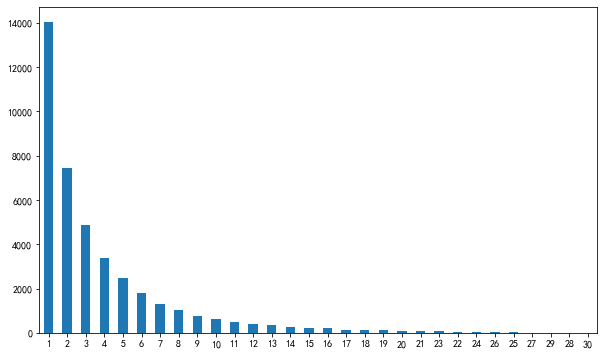

In [42]:
repay_user_period_day1.plot(kind='bar',figsize=(10, 6))
plt.xticks(rotation=0)

**复购周期集中在6天以内（有2000人以上会在6天内进行复购）**

# 10.RFM分析

In [43]:
nowdate = pd.to_datetime("2014-12-20")
buy_behavior = datas[datas["behavior_type"]==4]
recency = buy_behavior.groupby('user_id')['date'].apply(lambda x:nowdate - x.max())
print(recency.head(10))

user_id
4913      4 days
6118      3 days
7528      7 days
7591      7 days
12645     6 days
54056    13 days
63348     9 days
79824     4 days
88930     3 days
100539    4 days
Name: date, dtype: timedelta64[ns]


In [44]:
# 计算recency的平均值，用于衡量recency值的高低
recency_average = recency.mean()
recency_average = recency_average.days
recency_average

7

In [45]:
frequency = buy_behavior.groupby('user_id')['date'].apply(lambda x:x.count())
frequency.head(10)

user_id
4913       6
6118       1
7528       6
7591      21
12645      8
54056      2
63348      1
79824     13
88930     23
100539    18
Name: date, dtype: int64

In [46]:
datas_rfm = pd.merge(recency,frequency,left_on = 'user_id',right_on='user_id',how='outer')
datas_rfm = datas_rfm.rename(columns={'date_x':'recency','date_y':'frequency'})
datas_rfm.head(10)

,recency,frequency
user_id,,
4913,4 days,6
6118,3 days,1
7528,7 days,6
7591,7 days,21
12645,6 days,8
54056,13 days,2
63348,9 days,1
79824,4 days,13
88930,3 days,23


In [47]:
datas_rfm['recent_value'] = pd.qcut(datas_rfm.recency,2,labels=['2','1'])
datas_rfm['frequency_value'] = pd.qcut(datas_rfm.frequency,2,labels=['1','2'])
datas_rfm = datas_rfm.drop(columns=['recency','frequency'])
datas_rfm.head(10)

,recent_value,frequency_value
user_id,,
4913,2,1
6118,2,1
7528,1,1
7591,1,2
12645,2,1
54056,1,1
63348,1,1
79824,2,2
88930,2,2


**由于没有金额数据，因此只能从recency和frequency两个维度进行分析。 </br>
(recent_value, frequency_value)： </br>
（2，2）为重要价值客户 </br>
（1，2）为重要保持客户 </br>
（2，1）为重要发展客户 </br>
（1，1）为一般挽留客户**

In [48]:
# （2，2）：重要价值用户
important_valuable_customers = datas_rfm[(datas_rfm.recent_value == "2")&(datas_rfm.frequency_value == "2")]
important_valuable_customers.head(5) #打印前5条数据

,recent_value,frequency_value
user_id,,
79824,2,2
88930,2,2
100539,2,2
113960,2,2
151617,2,2


In [49]:
# （1，2）：重要保持客户
important_keeping_customers = datas_rfm[(datas_rfm.recent_value == "1")&(datas_rfm.frequency_value == "2")]
important_keeping_customers.head(5) #打印前5条数据

,recent_value,frequency_value
user_id,,
7591,1,2
109103,1,2
156608,1,2
157097,1,2
250843,1,2


In [50]:
# （2，1）：重要发展客户
important_developing_customers = datas_rfm[(datas_rfm.recent_value == "2")&(datas_rfm.frequency_value == "1")]
important_developing_customers.head(5) #打印前5条数据

,recent_value,frequency_value
user_id,,
4913,2,1
6118,2,1
12645,2,1
104155,2,1
120873,2,1


In [51]:
# （1，1）：一般挽留客户
normal_valuable_customers = datas_rfm[(datas_rfm.recent_value == "1")&(datas_rfm.frequency_value == "1")]
normal_valuable_customers.head(5) #打印前5条数据

,recent_value,frequency_value
user_id,,
7528,1,1
54056,1,1
63348,1,1
113251,1,1
134658,1,1


## 10.1 各种用户占比情况可视化

                customers_count
customers_type                 
重要价值客户                     3179
重要保持客户                     1219
重要发展客户                     1721
一般挽留客户                     2767


Text(0, 0.5, '')

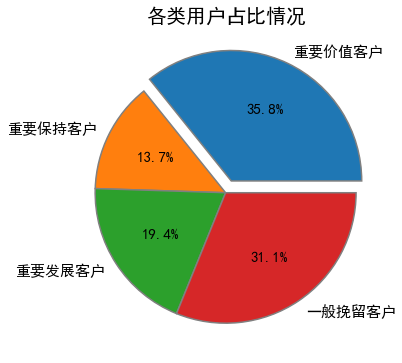

In [52]:
customers_count = [len(important_valuable_customers),len(important_keeping_customers),len(important_developing_customers),len(normal_valuable_customers)]
customers_type = ["重要价值客户","重要保持客户","重要发展客户","一般挽留客户"]
dic = {'customers_type':customers_type, 'customers_count': customers_count}
customers = pd.DataFrame(dic)
customers = customers.set_index("customers_type")
print(customers)
explode = (0.1, 0, 0, 0)
customers.plot(kind='pie',y='customers_count',autopct='%.1f%%', legend=False,fontsize=15,figsize=(6,6),wedgeprops = {'linewidth': 1.5, 'edgecolor':'grey'},explode=explode)
plt.title('各类用户占比情况', fontsize=20, fontweight='bold')
plt.ylabel('')

**从上方饼图可看出：</br>
1.重要价值客户占比高达35.8%，可着重关注这类客户并进行进一步的研究分析。</br>
2.其次是重要发展客户，占比接近20%，也是需要着重发展的一类客户。</br>
3.重要保持客户占13.7%，占比最小，但用户价值大，是不可忽视的一部分。</br>
4.最后是一般挽留客户，虽然这类用户价值较低，但其占比高达31.1%，可吸收利用该类用户的评价反馈用于改善经营情况。**

# 11.商品销量统计

In [53]:
goods_buy = datas[datas.behavior_type==4]
goods_buy_count = goods_buy.groupby('item_category')['action'].count().sort_values(ascending=False)
# 销量前10名的商品种类
goods_buy_count.reset_index().rename(columns={'action':'sales '}).head(10)

,item_category,sales
0,6344,2208
1,1863,2000
2,5232,1611
3,6977,1324
4,8877,1072
5,6513,1059
6,5399,1054
7,3424,1053
8,3472,1038
9,7957,997


Text(0, 0.5, '销量')

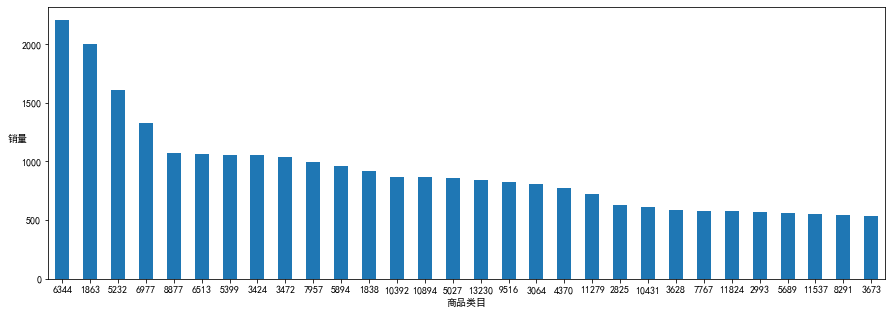

In [54]:
goods_buy_count.head(30).plot(kind="bar",x="item_category",y="sales",figsize=(15,5))
plt.xticks(rotation=0)
plt.xlabel('商品类目')
plt.ylabel('销量',rotation=0)

In [55]:
# 销量前10名的商品
goods_id = goods_buy.groupby('item_id')['action'].count().sort_values(ascending=False)
goods_id.reset_index().rename(columns={'action':'sales'}).head(10)

,item_id,sales
0,303205878,50
1,14087919,35
2,115124482,31
3,243091690,29
4,167074648,28
5,109259240,24
6,127914633,24
7,101795752,23
8,374214353,23
9,17065447,22


Text(0, 0.5, '销量')

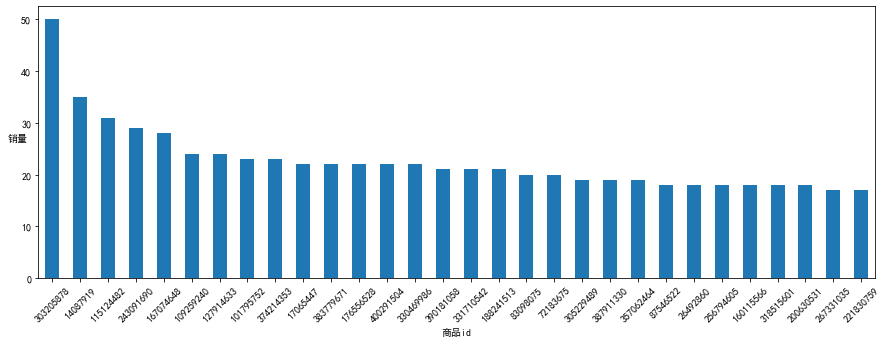

In [56]:
goods_id.head(30).plot(kind="bar",figsize=(15,5))
plt.xticks(rotation=45)
plt.xlabel('商品id')
plt.ylabel('销量',rotation=0)